# MLP 

In [13]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline

import requests 
from tqdm import tqdm

In [14]:
with open( "names.txt") as f:
    words = (f.read().lower()).split()

In [15]:
len(words)

32033

In [16]:
chars = sorted(list(set((''.join(words)))))  #get unique characters 
stoi = {s:i+1 for i, s in enumerate(chars)}  # map char to int
stoi["."] = 0 
itos = {i:s for s, i in stoi.items()}        # map int to char

In [152]:
# build the dataset
block_size = 10 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182580, 10]) torch.Size([182580])
torch.Size([22767, 10]) torch.Size([22767])
torch.Size([22799, 10]) torch.Size([22799])


In [168]:
n_dim = 4

C = torch.randn((27, n_dim)) 
W1 = torch.randn((n_dim * block_size, 200)) / ((5/3) / (n_dim * block_size)**0.5)
b1 = torch.randn(200 ) * 0.0
W2 = torch.randn((200, 27) ) /((200)**0.5)
b2 = torch.randn(27) * 0.0
parameters = [C, W1, b1, W2, b2]


In [169]:
sum(p.nelement() for p in parameters) # number of parameters in total
for p in parameters:
  p.requires_grad = True

In [170]:
stepi = []; lossi=[]

In [171]:
W2.std()

tensor(0.0706, grad_fn=<StdBackward0>)

In [172]:
its = 10000
for i in tqdm(range(its)):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (512,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, n_dim*block_size) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = torch.linspace(0.1, 0.05, its)
  for p in parameters:
    p.data += -lr[i] * p.grad

  # track stats
  #lri.append(lre[i])
  if i%100 ==0:print(loss.item())
  stepi.append(i)
  lossi.append(loss.log10().item())
   


  2%|▏         | 173/10000 [00:00<00:11, 873.19it/s]

3.8703458309173584
2.641650676727295


  4%|▎         | 359/10000 [00:00<00:10, 909.85it/s]

2.528485059738159
2.5241756439208984


  5%|▌         | 541/10000 [00:00<00:11, 843.04it/s]

2.4623827934265137
2.4176230430603027


  7%|▋         | 731/10000 [00:00<00:10, 898.53it/s]

2.3760900497436523
2.4378345012664795


  9%|▉         | 920/10000 [00:01<00:09, 916.49it/s]

2.4348769187927246
2.396982431411743


 11%|█         | 1094/10000 [00:01<00:11, 791.32it/s]

2.4344513416290283
2.4631154537200928


 14%|█▎        | 1358/10000 [00:01<00:10, 850.60it/s]

2.3361425399780273
2.471872091293335


 15%|█▌        | 1540/10000 [00:01<00:09, 878.01it/s]

2.36437726020813
2.3681461811065674


 17%|█▋        | 1724/10000 [00:01<00:09, 898.31it/s]

2.4000062942504883
2.3783628940582275


 19%|█▉        | 1907/10000 [00:02<00:08, 902.15it/s]

2.255702018737793
2.4027352333068848


 21%|██        | 2093/10000 [00:02<00:08, 908.57it/s]

2.4330551624298096
2.2542576789855957


 24%|██▎       | 2364/10000 [00:02<00:08, 884.11it/s]

2.2705109119415283
2.4321186542510986


 25%|██▌       | 2541/10000 [00:02<00:09, 792.78it/s]

2.41162109375
2.305812358856201


 27%|██▋       | 2720/10000 [00:03<00:08, 840.68it/s]

2.295057535171509
2.2806429862976074


 29%|██▉       | 2900/10000 [00:03<00:08, 864.79it/s]

2.2821505069732666
2.303222894668579


 32%|███▏      | 3182/10000 [00:03<00:07, 912.40it/s]

2.3516416549682617
2.324902057647705


 34%|███▎      | 3367/10000 [00:03<00:07, 916.91it/s]

2.260011911392212
2.2467050552368164


 36%|███▌      | 3553/10000 [00:04<00:07, 918.49it/s]

2.323335647583008
2.296086311340332


 37%|███▋      | 3737/10000 [00:04<00:06, 916.48it/s]

2.31289005279541
2.284116268157959


 39%|███▉      | 3921/10000 [00:04<00:06, 910.77it/s]

2.236828088760376
2.3261919021606445


 41%|████      | 4105/10000 [00:04<00:07, 826.08it/s]

2.288590669631958
2.3280866146087646


 44%|████▍     | 4384/10000 [00:04<00:06, 892.84it/s]

2.391498565673828
2.4304256439208984


 46%|████▌     | 4566/10000 [00:05<00:06, 882.39it/s]

2.2848169803619385
2.2749292850494385


 47%|████▋     | 4749/10000 [00:05<00:05, 897.14it/s]

2.2476048469543457
2.2345492839813232


 49%|████▉     | 4934/10000 [00:05<00:05, 908.08it/s]

2.2711429595947266
2.332158327102661


 51%|█████     | 5117/10000 [00:05<00:05, 905.12it/s]

2.344548463821411
2.3261332511901855


 53%|█████▎    | 5303/10000 [00:06<00:05, 910.91it/s]

2.4065358638763428
2.332998037338257


 56%|█████▌    | 5584/10000 [00:06<00:04, 917.17it/s]

2.2916007041931152
2.273894786834717


 57%|█████▋    | 5676/10000 [00:06<00:04, 911.77it/s]

2.213536024093628
2.2889151573181152


 59%|█████▉    | 5948/10000 [00:06<00:04, 845.26it/s]

2.308244228363037
2.2844648361206055


 61%|██████▏   | 6130/10000 [00:06<00:04, 875.26it/s]

2.3497042655944824
2.270714044570923


 63%|██████▎   | 6313/10000 [00:07<00:04, 873.83it/s]

2.2725605964660645
2.291121244430542


 65%|██████▍   | 6487/10000 [00:07<00:04, 834.75it/s]

2.33467698097229
2.2561211585998535


 67%|██████▋   | 6738/10000 [00:07<00:04, 806.21it/s]

2.326943874359131
2.2771105766296387


 69%|██████▉   | 6898/10000 [00:07<00:04, 757.31it/s]

2.3314719200134277
2.3380370140075684


 71%|███████▏  | 7130/10000 [00:08<00:03, 752.89it/s]

2.2771382331848145
2.372346878051758


 73%|███████▎  | 7281/10000 [00:08<00:03, 740.16it/s]

2.246842384338379
2.3501670360565186


 75%|███████▌  | 7514/10000 [00:08<00:03, 652.66it/s]

2.2865610122680664
2.200622320175171


 77%|███████▋  | 7744/10000 [00:09<00:03, 720.49it/s]

2.2756552696228027
2.3123855590820312


 79%|███████▉  | 7897/10000 [00:09<00:02, 735.89it/s]

2.3106024265289307
2.2401208877563477


 81%|████████▏ | 8133/10000 [00:09<00:02, 752.75it/s]

2.3273684978485107
2.2322275638580322


 83%|████████▎ | 8284/10000 [00:09<00:02, 733.20it/s]

2.3486809730529785
2.2615790367126465


 85%|████████▌ | 8527/10000 [00:10<00:01, 760.93it/s]

2.2893645763397217
2.2513234615325928


 87%|████████▋ | 8681/10000 [00:10<00:01, 663.92it/s]

2.2637200355529785
2.28035044670105


 89%|████████▉ | 8902/10000 [00:10<00:01, 712.34it/s]

2.2252700328826904
2.343569040298462


 91%|█████████ | 9060/10000 [00:11<00:01, 617.22it/s]

2.1860270500183105
2.3540422916412354


 93%|█████████▎| 9293/10000 [00:11<00:00, 718.51it/s]

2.2994158267974854
2.3198697566986084


 95%|█████████▌| 9536/10000 [00:11<00:00, 768.28it/s]

2.291600227355957
2.329482078552246


 97%|█████████▋| 9692/10000 [00:11<00:00, 751.03it/s]

2.3110225200653076
2.235665798187256


 99%|█████████▉| 9935/10000 [00:12<00:00, 765.60it/s]

2.3150341510772705
2.3152353763580322


100%|██████████| 10000/10000 [00:12<00:00, 816.64it/s]


In [173]:
loss.item()

2.2158899307250977

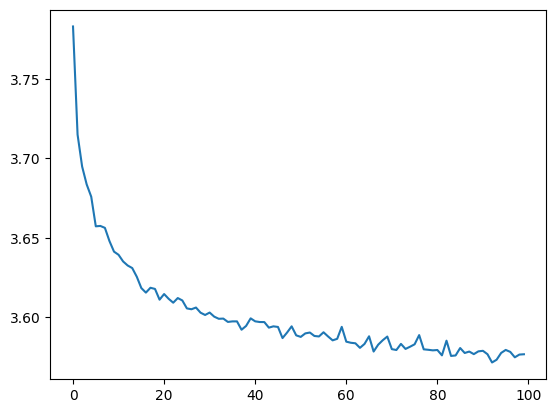

In [174]:
plt.plot( torch.tensor(lossi).view(-1,100).sum(axis=1).log().numpy())

In [142]:
@torch.no_grad()
def split_loss(split):
    x,y={
        'train':(Xtr,Ytr),
        'val':(Xdev,Ydev),
        'test':(Xte,Yte)
    }[split]

    emb=C[x]
    emcat = emb.view(emb.shape[0],-1)
    h = torch.tanh(emcat@ W1 + b1)
    logits = h @ W2 +b2
    loss = F.cross_entropy(logits, y)
    print(split,loss.item())

split_loss('train')
split_loss('val')
# split_loss('test')

train 2.30290150642395
val 2.300346612930298


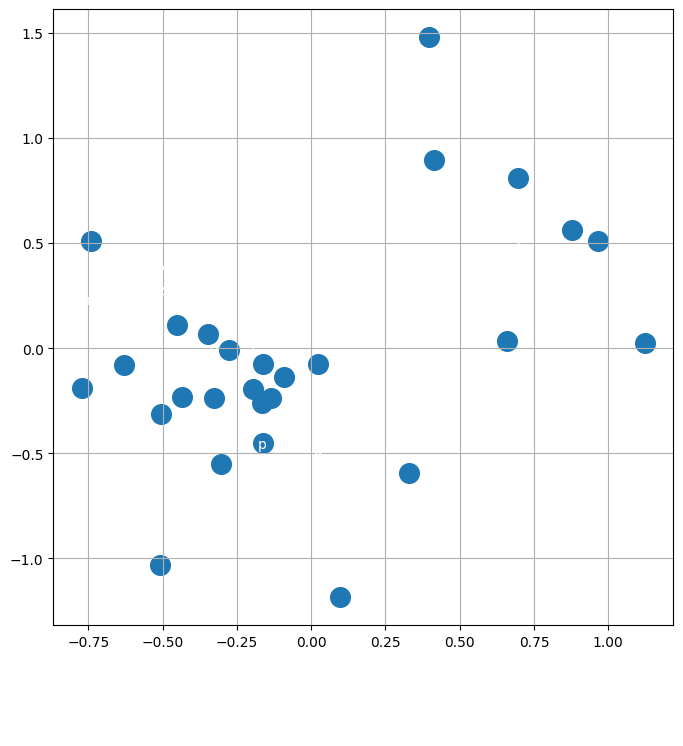

In [143]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,2].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [145]:
# sample from the model
# g = torch.Generator().manual_seed(2147483647 + 89)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

setivy.
aviodauk.
ea.
onee.
kaum.
andryala.
fovion.
karrio.
breerzo.
diratme.
anzadi.
laedah.
reruko.
ducuelan.
kasdlie.
gvdytge.
cebyl.
bonana.
nanika.
dariota.
